In [1]:
from google.colab import drive
drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


I realize that the number of slices is not constant; therefore, with the code below I find the minimum value of slices with which I will then unify the dataset

In [2]:
import nibabel as nib
import numpy as np
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  #raise SystemError('GPU device not found')
  print("Pazienza")
print('Found GPU at: {}'.format(device_name))

from skimage.io import imread, imshow
from skimage import data
from skimage.transform import resize
import matplotlib.pyplot as plt


Found GPU at: /device:GPU:0


In [3]:
!pip install git+https://github.com/qubvel/segmentation_models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-9t9icp81
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-9t9icp81
  Running command git submodule update --init --recursive -q


In [ ]:
PATH = '/content/drive/MyDrive/Progetto/kits19/data'
DATA_CT = '/imaging.nii.gz'
SEGM_CT = '/segmentation.nii.gz'

START_TRAIN = 0
END_TRAIN = 75

START_TEST = 75
END_TEST = 100

DATA_AUGM = False



In [ ]:
min_slice = 50000
case_val = 0
img = []
img_path = DATA_CT

for i in range(0, 300):
    img = nib.load(PATH+'/case_'+f'{i:05d}'+img_path)
    slice_val = img.shape[0]
    if min_slice >= slice_val:
      case_val = i
      min_slice = slice_val


print(min_slice)
print(case_val)

Therefore the minimum number of slices will be 29. The size of the images is 512x512 in all cases but 161 which is 256x256. In addition, only the first 209 patients have a mask. So, for simplicity, I'll consider only the first 100 patients, 75% for training and 25% for testing. I'll also consider an arbitrary subset of slices for limitations due to performance with Colab Free

In [ ]:
def get_images(start, stop, img_path):
  images = []


  for cases in range(start, stop):
    # loading the images
    img = nib.load(PATH+'/case_'+f'{cases:05d}'+img_path)
    img = img.get_fdata()

    #for hardware reasons I'm resampling the images with size 256x256 and a number of slices equal to the minimum present in the set (29 case_00061)
    img = resize(img, (29,256,256), order=1, preserve_range=True)


    # I add them to the set of images by normalizing them at the same time
    for j in range(0, img.shape[0]):
      images.append(img[j, :, :]/255)
    print(cases)

  return images


In [ ]:
print('-------------------')
print('Getting training dataset')
trainSet_ct = np.array(get_images(START_TRAIN, END_TRAIN, DATA_CT))
print('Loading of the training set done!')
trainSet_seg = np.array(get_images(START_TRAIN, END_TRAIN, SEGM_CT))

print('Loading of the mask done!')
print('-------------------')

Below some debugging code to see if has worked

Dataset length: 2175


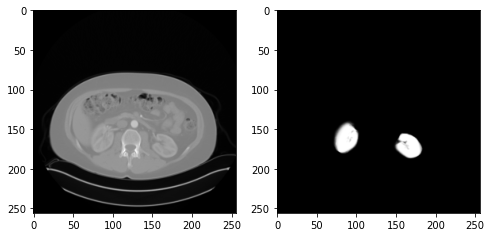

In [ ]:
val = 10
print("Dataset length:", len(trainSet_ct))
fig = plt.figure(figsize=(8,8))
a = fig.add_subplot(1,2,1)
imgplot = plt.imshow(trainSet_ct[val], cmap = 'gray')
a = fig.add_subplot(1,2,2)
imgplot = plt.imshow(trainSet_seg[val], cmap = 'gray')

In [ ]:
print('-------------------')
print('Getting testing dataset')
testCT = np.array(get_images(START_TEST, END_TEST, DATA_CT))
print('Loading of the testing set done!')
testLabel = np.array(get_images(START_TEST, END_TEST, SEGM_CT))
print('Loading of the mask done!')
print('-------------------')

Here an option to save the array for debugging

In [ ]:
with open('/content/drive/MyDrive/Progetto/Saved arrays/Training/Originals/IMMAGINI_TRAINING_CT.npy', 'wb') as f:
    np.save(f, trainSet_ct)
with open('/content/drive/MyDrive/Progetto/Saved arrays/Training/Labels/IMMAGINI_TRAINING_LABEL.npy', 'wb') as f:
  np.save(f, trainSet_seg)   
with open('/content/drive/MyDrive/Progetto/Saved arrays/Test/Originals/IMMAGINI_TEST_CT.npy', 'wb') as f:
  np.save(f, testCT)   
with open('/content/drive/MyDrive/Progetto/Saved arrays/Test/Labels/IMMAGINI_TEST_LABEL.npy', 'wb') as f:
  np.save(f, testLabel)   


In [14]:
trainSet_ct = np.load('/content/drive/MyDrive/Progetto/Saved arrays/Training/Originals/IMMAGINI_TRAINING_CT.npy',  mmap_mode='r')
trainSet_seg = np.load('/content/drive/MyDrive/Progetto/Saved arrays/Training/Labels/IMMAGINI_TRAINING_LABEL.npy',  mmap_mode='r')
trainSet_seg = trainSet_seg*255

With the following code I encode the mask so that I have an index for each class

In [ ]:
def ConvertOneHotEncoded(images):
  '''
  This function converts the mask to one-hot-encoding so that index 0 is 'backround', index 1 is 'kidneys', index 2 is 'tumor'
  ''' 
  one_hot_images = []

  N = 256

  # Iterate over the images in the list
  for image in images:
      # Initialize the one-hot encoded array with all elements set to 0
      image_one_hot = np.zeros((N, N, 3), dtype=np.float64)

      # Iterate over the rows and columns of the image
      for i in range(N):
          for j in range(N):
              # Get the pixel value at position (i, j)
              pixel_value = int(image[i, j])
              # Set the corresponding element in the one-hot encoded array to 1 
              image_one_hot[i, j, pixel_value] = 1
              
      # Add the one-hot encoded image to the list
      one_hot_images.append(image_one_hot)

  return np.array(one_hot_images)

This code does the exact opposite; it will be useful when we'll want to show the predicted values

In [17]:
def ConvertFromOneHotEncoded(one_hot_images):
    '''
    This function converts one-hot-encoded images back to the original format
    '''
    images = []

    N = 256

    # Iterate over the one-hot encoded images in the list
    for one_hot_image in one_hot_images:
        # Initialize the image array with all elements set to 0
        image = np.zeros((N, N), dtype=np.uint8)

        # Iterate over the rows and columns of the one-hot encoded image
        for i in range(N):
            for j in range(N):
                # Get the index of the element with value 1 in the one-hot encoded image
                pixel_value = np.argmax(one_hot_image[i, j])
                # Set the corresponding element in the image to the index
                image[i, j] = pixel_value

        # Add the image to the list
        images.append(image)

    return np.array(images)


To do multiclass segmentation I have to convert my single-channel images to three channel ones

In [12]:
def greyscaleToThreeChannel(original):
  '''Returns the numpy array triplicated '''
  result = np.stack((original,)*3, axis=-1)
  del original

In [ ]:
#this will convert our greyscale image into a three-channel one. I convert it to float32 to save some space
x = greyscaleToThreeChannel(trainSet_ct).astype('float32')

y = ConvertOneHotEncoded(trainSet_seg).astype('float32')

del trainSet_seg

In [7]:
print("Check:", x.shape, y.shape)

Check: (2175, 256, 256, 3) (2175, 256, 256, 3)


In [ ]:
with open('/content/drive/MyDrive/Progetto/Saved arrays/x.npy', 'wb') as f:
    np.save(f, x)
with open('/content/drive/MyDrive/Progetto/Saved arrays/y.npy', 'wb') as f:
  np.save(f, y) 

In [4]:
x = np.load('/content/drive/MyDrive/Progetto/Saved arrays/x.npy',  mmap_mode='r')
y = np.load('/content/drive/MyDrive/Progetto/Saved arrays/y.npy',  mmap_mode='r')

In [8]:
import gc
gc.collect()

1381

Below a plot to see if the encoding of the mask has worked

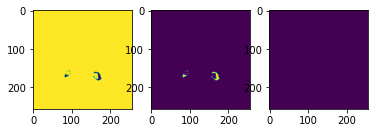

In [30]:
def show_classes(y, slice_ex = 10):
  


  background_ex = y[slice_ex,:,:,0]
  kidney_ex = y[slice_ex,:,:,1]
  tumor_ex = y[slice_ex,:,:,2]

  # Create a figure with a 3x1 grid of subplots
  fig, ax = plt.subplots(1, 3)

  ax[0].imshow(background_ex)

  ax[1].imshow(kidney_ex)

  ax[2].imshow(tumor_ex)

  plt.show()

show_classes(y)

Since I don't have balanced classes I have to assign different weights to each classes. So what we wanna do is calculate the percentage of each class in the mask

In [17]:
def calculatePercentageClasses(mask):
  background = mask[:,:,:,0]
  kidney = mask[:,:,:,1]
  tumor = mask[:,:,:,2]

  x = np.count_nonzero(background)
  y = np.count_nonzero(kidney)
  z = np.count_nonzero(tumor)

  return (x/background.size*100, y/kidney.size*100, z/tumor.size*100)

print(calculatePercentageClasses(y))

(99.53942941249102, 0.392303116020115, 0.06826747148886494)


With the following code I'm using a pretrained uNet model with 'imagenet' to do multiclass segmentation. To make things easiear I imported a library from this repository https://github.com/qubvel/segmentation_models

As the upper code showed the percentages are the following:
- background: 99.54&
- kidneys: 0.39%
- tumors: 0.06&

So, to have balanced classes, so that each one contributes equally, I'll assign as a weight 1/(percentage)

In [6]:
w_b = int(100/(99.54))
w_k = int(100/0.39)
w_t = int(100/0.06)

print(w_b, w_k, w_t)

1 256 1666


In [7]:
import segmentation_models as sm
from keras.layers import Input, Conv2D
from keras.models import Model
import numpy as np
import keras

keras.backend.set_image_data_format('channels_last')


model = sm.Unet('resnet34', classes = 3, activation = 'softmax')

#assigning different weight since the classes are not distributed equally 
#dice_loss = sm.losses.DiceLoss(class_weights=np.array([w_b, w_k*2, w_t*2])) 
#focal_loss = sm.losses.CategoricalFocalLoss()
#total_loss = dice_loss #+ (1 * focal_loss)

total_loss = sm.losses.CategoricalCELoss(class_weights=np.array([w_b, w_k*2, w_t*2]))

metrics = [sm.metrics.IOUScore(threshold=0.5, class_weights = np.array([0, 1, 1])), sm.metrics.FScore(threshold=0.5, class_weights = np.array([0, 1, 1]))]

model.compile(
    'Adam',
    loss = total_loss,
    metrics= metrics,
)

callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]





model.fit(
   x,
   y,
   batch_size=16,
   epochs=20,
   validation_split = 0.1,
  callbacks = callbacks
)


Segmentation Models: using `keras` framework.
Epoch 1/20
123/123 [==============================] - 60s 354ms/step - loss: 1.3839 - iou_score: 0.0160 - f1-score: 0.0208 - val_loss: 58.2066 - val_iou_score: 3.8318e-08 - val_f1-score: 3.8318e-08 - lr: 0.0010
Epoch 2/20
123/123 [==============================] - 35s 282ms/step - loss: 1.0966 - iou_score: 0.0265 - f1-score: 0.0358 - val_loss: 11.7323 - val_iou_score: 0.3810 - val_f1-score: 0.3810 - lr: 0.0010
Epoch 3/20
123/123 [==============================] - 34s 280ms/step - loss: 1.1712 - iou_score: 0.0161 - f1-score: 0.0210 - val_loss: 32.7789 - val_iou_score: 0.0476 - val_f1-score: 0.0476 - lr: 0.0010
Epoch 4/20
123/123 [==============================] - 34s 279ms/step - loss: 1.1251 - iou_score: 0.0275 - f1-score: 0.0353 - val_loss: 16.4414 - val_iou_score: 0.3571 - val_f1-score: 0.3571 - lr: 0.0010
Epoch 5/20
123/123 [==============================] - 34s 279ms/step - loss: 1.0418 - iou_score: 0.0606 - f1-score: 0.0711 - val_loss:

In [9]:
testCT = np.load('/content/drive/MyDrive/Progetto/Saved arrays/Test/Originals/IMMAGINI_TEST_CT.npy' ,  mmap_mode='r')
testLabel = np.load('/content/drive/MyDrive/Progetto/Saved arrays/Test/Labels/IMMAGINI_TEST_LABEL.npy',  mmap_mode='r')

In [11]:
trainSet_ct = np.load('/content/drive/MyDrive/Progetto/Saved arrays/Training/Originals/IMMAGINI_TRAINING_CT.npy',  mmap_mode='r')
trainSet_seg = np.load('/content/drive/MyDrive/Progetto/Saved arrays/Training/Labels/IMMAGINI_TRAINING_LABEL.npy',  mmap_mode='r')
trainSet_seg = trainSet_seg*255

In [9]:
preds_train = model.predict(x, verbose=1)
del x 
#preds_test = model.predict(greyscaleToThreeChannel(testCT), verbose=1)


preds_train_t = (preds_train > 0.5).astype(np.uint8)
#preds_test_t = (preds_test > 0.5).astype(np.uint8)

68/68 [==============================] - 15s 173ms/step


In [12]:
import random

seed = 42
np.random.seed = seed
idx = random.randint(0, len(trainSet_ct))
idy = random.randint(0, len(trainSet_seg))


In [15]:
def modelCheck(trainOriginals, trainLabels, preds_train_t):

    ix = random.randint(0, len(preds_train_t))
    # Load the original image, label, and predicted label
    orig_image = trainOriginals[ix]
    orig_label = trainLabels[ix]
    pred_kidney = preds_train_t[ix][:,:,1]
    pred_tumor = preds_train_t[ix][:,:,1]

    # Create a figure with three subplots
    fig, axs = plt.subplots(1, 4, figsize=(15, 5))

    # Display the original image in the first subplot
    axs[0].imshow(orig_image)
    axs[0].set_title("Original image")

    # Display the original label in the second subplot
    axs[1].imshow(orig_label)
    axs[1].set_title("Original label")

    # Display the predicted label in the third subplot
    axs[2].imshow(pred_kidney)
    axs[2].set_title("Predicted kidney")

    axs[3].imshow(pred_tumor)
    axs[3].set_title("Predicted tumor")

    plt.show()

In [18]:
result = ConvertFromOneHotEncoded(preds_train_t)
result.shape

(2175, 256, 256)

--------------------
Training check: 


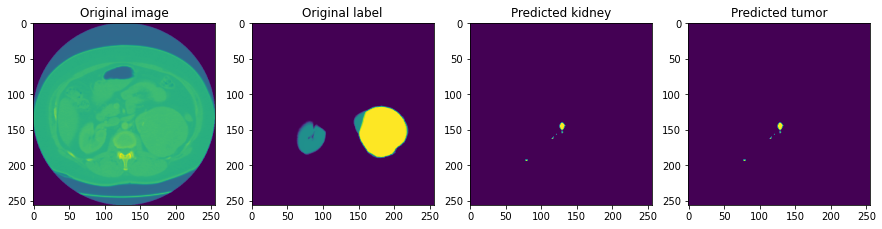

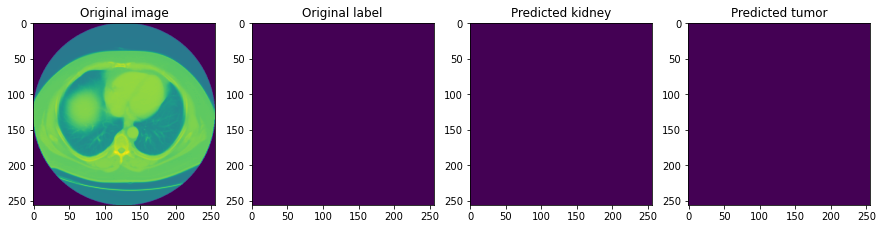

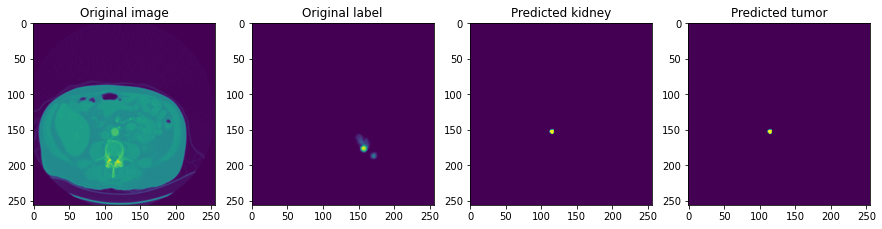

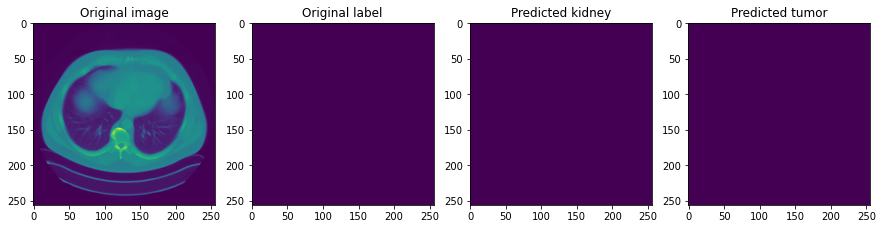

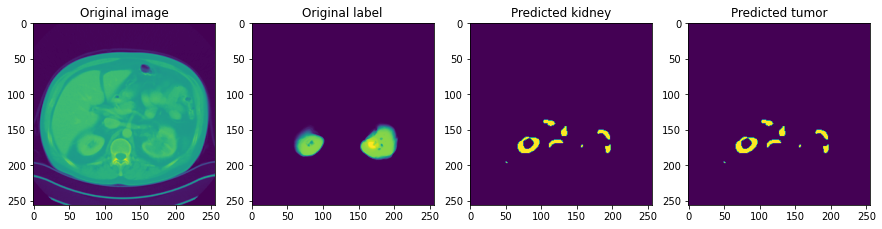

In [17]:
# Check on some random training samples
print('--------------------')
print('Training check: ')
for i in range(5):
  modelCheck(trainSet_ct, trainSet_seg, preds_train_t)
print('-------------------')
print('///////////////////')
print('-------------------')
print(' ')
print('Training check: ')
#for i in range(5):
#  modelCheck(testCT, testLabel, preds_test_t)